In [177]:
import importlib
plotting_utils=importlib.reload(plotting_utils)

In [158]:
import pandas as pd
import numpy as np
from Bio import SeqIO, Seq, Data
import plotting_utils

import matplotlib.pyplot as plt
# nice plotting
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"


In [164]:
class VariationDataset:
    """
    Class to hold and process sequence variation and phenotypic data. For each gene, the
    following data should be provided (via input `seq_data_paths` in at instantiation):
        * A Pandas DataFrame of variants with columns
            - `var_id` (as index): generally of the form chr:pos:ref:alt, but can be something else
            - `AA_POS`, `AA_REF`, `AA_ALT`, `AA_STRAND`: the position and strand of the
              variant, and the reference and alternate alleles
            - Other optional information (e.g. allele counts/frequencies from VCF file)
        * A Pandas DataFrame of patients and their sequences with columns:
            - `patient_id` (as index): the ID of each patient
            - `seq_id`: the ID of a patient's sequence
            - Other optional information (e.g. the number of variants per sequence, the 
              IDs of each variant per sequence, sequence counts)
        * A Pandas DataFrame of unique sequences with columns:
            - `seq_id` (as index): the ID of a unique sequence
            - `vars_list`: the variant IDs in the sequence, joined with '_', like an 
              adjacency list
            - `n_vars`: the number of variants in the sequence
            - `seq_count`: the count of  a unique sequence in the data 
        * The sequence data (either one-hot encoding or some embedding), saved as an
          binary `.npy` array
    
    NOTE: the Pandas DataFrames are expected to be stored as `.parquet` files.
          
    The phenotypic data should be a Pandas DataFrame stored as a `.parquet` file, and it
    must contain a `patient_id` column that matches the identically-named column in each
    sequence table
    
    NOTE: The class can be given the variation data for one or more genes. Gene-specific  
    suffixes will be added to the appropriate column names to reduce confusion.
    
    """
    
    def __init__(self, seq_data_paths, phen_data):
        """        
        -----------------------------------------------------------------------------------
        Inputs          | Description
        ----------------+------------------------------------------------------------------
        seq_data_paths  | Two-level dictionary. First level of keys should be the sequence 
                        | (gene) names, and the second level dictionaries should be like:
                        | {'variants': VARIANTS_TABLE_PATH, 
                        |  'sequences': SEQUENCE_TABLE_PATH, 
                        |  'patients': PATIENT_DATA_PATH, 
                        |  'seqdata': SEQUENCE_DATA_PATH,
                        |  'seqfasta': FASTA_SEQUENCES_PATH,
                        |  'seqvarmatrix': SEQUENCE_VARIANT_MATRIX}
        ----------------+------------------------------------------------------------------
        phen_data       | Dataframe with index `patient_id` and phenotype columns
        -----------------------------------------------------------------------------------
        
        """
        self.seq_data_paths = seq_data_paths
        self.phen_data_path = phen_data
        self.gene_names = list(seq_data_paths.keys())
        self.n_genes = len(self.gene_names)
        self.many_genes = (self.n_genes > 1)
        
        self.variants = {s:None for s in self.gene_names}
        self.sequences = {s:None for s in self.gene_names}
        self.patients = {s:None for s in self.gene_names}
        self.seqdata = {s:None for s in self.gene_names}
        self.seqfasta = {s:None for s in self.gene_names}
        self.seqvarmatrix = {s:None for s in self.gene_names}
        
        # read tables and data
        self.summary = {}
        total_seq_length, total_n_vars = 0, 0
        
        for gene in self.gene_names:
            print(f'Fetching {gene} data ...', end=" ")
            self.variants[gene] = pd.read_parquet(seq_data_paths[gene]['variants'])
            self.sequences[gene] = pd.read_parquet(seq_data_paths[gene]['sequences'])
            self.patients[gene] = pd.read_parquet(seq_data_paths[gene]['patients'], 
                                                 columns = ['n_vars', 'seq_id'])\
                                    .add_prefix(f"{gene}:" if self.many_genes else "")
            self.seqdata[gene] = np.load(seq_data_paths[gene]['seqdata'], 
                                         mmap_mode='r+')
            # self.seqfasta[gene] = SeqIO.read(seq_data_paths[gene]['seqfasta'], "fasta")
            self.seqvarmatrix[gene] = np.load(seq_data_paths[gene]['seqvarmatrix'], 
                                              mmap_mode='r+')
            
            total_seq_length += self.seqdata[gene].shape[1]
            total_n_vars += len(self.variants[gene])
            self.summary[gene] = {"length": self.seqdata[gene].shape[1], 
                                  "n_vars": len(self.variants[gene]), 
                                  "n_seqs": len(self.sequences[gene])}
            print("Done.")
        
        if not self.many_genes:
            self.variants = self.variants[gene]
            self.sequences = self.sequences[gene]
            self.patients = self.patients[gene]
            self.data = self.data[gene]
        else:
            # combine patient sequences
            self.patients = pd.concat(self.patients.values(), axis = 1)
            # sum the number of variants per patient
            self.patients['n_vars'] = self.patients.loc[:,self.patients.columns.str.contains('n_vars')].sum(1)
            # combine the sequence IDs across all genes to generate new network-level sequence IDs
            self.patients['jointed_seq_ids'] = self.patients\
                                                .loc[:, self.patients.columns.str.contains('seq_id')]\
                                                .agg(':'.join, axis = 1)
            # create new sequences table
            sequences = self.patients.copy(deep=True).drop_duplicates(subset = ['jointed_seq_ids'])
            sequences.index = [f"xseq_{i}" for i in range(len(sequences))]
            sequences.index.name = 'new_seq_id'
            # assign combined sequence IDs to patients
            self.patients = pd.merge(left = self.patients.reset_index(), 
                                     right = sequences.reset_index()[['jointed_seq_ids', 'new_seq_id']], 
                                     left_on = 'jointed_seq_ids', 
                                     right_on = 'jointed_seq_ids', 
                                     how = 'left')
            
            self.patients = self.patients[["patient_id", "n_vars", "new_seq_id"]]\
                                                    .astype({'new_seq_id': 'category'})\
                                                    .set_index("patient_id")
            
            # count combined sequences
            seq_counts = self.patients['new_seq_id'].value_counts().rename('seq_count')
            seq_counts = seq_counts.astype('int32')
            sequences = pd.merge(left = sequences, 
                                 right = seq_counts,
                                 left_on = "new_seq_id", 
                                 right_index = True,
                                 how = "left")
            
            # resplit the combined sequence IDs in the sequences table
            sequences[self.gene_names] = sequences['jointed_seq_ids'].str.split(':', expand = True)
            sequences = sequences.drop(columns = ['jointed_seq_ids'])
            
            self.sequences['all'] = sequences
            
            # add to summary
            self.summary['all_genes'] = {'length' : total_seq_length, 
                                         'n_vars': total_n_vars, 
                                         'n_seqs': len(sequences)}
            
        self.summary = pd.DataFrame(self.summary).T
            
        self.seq_lengths = self.summary['length'].tolist() 
        self.n_sequences = self.summary['n_seqs'].tolist() 
        if not self.many_genes: 
            self.seq_lengths, self.n_sequences = self.seq_lengths[0], self.n_sequences[-1]
            self.seq_idxs = np.arange(0, self.n_sequences)
                
    def weights(self, t):
        """
        Calculate the training weights of the sequences using their counts in the population. 
        Parameter t <= 1 is to flatten the distribution (smaller t leads to flatter distributions):
        
        w'_i = c_i / (sum_j c_j)
        w_i = w'_i^t / (sum_j w'_j^t)
        
        """
        counts = self.sequences['seq_count'].to_numpy()
        weights = counts/counts.sum()
        weights = weights ** t
        return weights/weights.sum()

In [169]:
with open("gene_list.txt", 'r') as file:
    gene_list = [x.strip() for x in file.readlines()]

seq_data_paths = {g:{'variants': f'data/data/{g}/variants_table.parquet', 
                     'sequences': f'data/data/{g}/seq_table.parquet', 
                     'patients': f'data/data/{g}/patients_table.parquet', 
                     'seqdata': f'data/data/{g}/seq_data.npy',
                     'seqfasta': f'data/data/{g}/seqs.fasta',
                     'seqvarmatrix': f'data/data/{g}/seq_var_matrix.npy'} for g in gene_list}

In [27]:
phendata = {}

In [ ]:
phendata['41270'] = pd.read_csv("../../../all_phenotyes_aug2022/split_phenotypes/41270.csv", low_memory=False)
phendata['41270'] = phendata['41270'].rename(columns={'eid':'patient_id'}).set_index('patient_id')
phendata['41270'] = phendata['41270'].fillna('')
phendata['41270'] = phendata['41270'].apply(lambda x: '_'.join(filter(None, x)), axis=1).to_frame('combined_icd_10')

In [ ]:
phendata['41202'] = pd.read_csv("../../../all_phenotyes_aug2022/split_phenotypes/41202.csv", low_memory=False)
phendata['41202'] = phendata['41202'].rename(columns={'eid':'patient_id'}).set_index('patient_id')
phendata['41202'] = phendata['41202'].fillna('')
phendata['41202'] = phendata['41202'].apply(lambda x: '_'.join(filter(None, x)), axis=1).to_frame('combined_main_icd_10')

In [ ]:
phendata['41204'] = pd.read_csv("../../../all_phenotyes_aug2022/split_phenotypes/41204.csv", low_memory=False)
phendata['41204'] = phendata['41204'].rename(columns={'eid':'patient_id'}).set_index('patient_id')
phendata['41204'] = phendata['41204'].fillna('')
phendata['41204'] = phendata['41204'].apply(lambda x: '_'.join(filter(None, x)), axis=1).to_frame('combined_secondary_icd_10')

In [73]:
phendata['131338'] = pd.read_csv("../../../all_phenotyes_aug2022/split_phenotypes/131338.csv", low_memory=False)
phendata['131338'] = phendata['131338'].set_index('eid')
phendata['131338'] = phendata['131338'].rename(columns={'131338-0.0':'I42_date'})
phendata['131338'] = phendata['131338'].fillna(0)

In [95]:
phendata['131338'][~(phendata['131338']['I42_date']==0)]

,I42_date
eid,
1001057,2019-08-01
1001264,2015-06-19
1002523,2016-07-14
1004238,2021-02-16
1005392,2009-07-14
...,...
6017828,2016-03-23
6018714,2007-06-09
6022440,2012-01-25


In [75]:
data_i42 = pd.concat([phendata['41270'], phendata['41202'], phendata['41204'], phendata['131338']],
                      axis = 1,
                      ignore_index = False,
                      join = 'outer')

In [76]:
def check_icd_code(s, p):
    if p in s: return 1
    else: return 0

In [81]:
data_i42 = data_i42.apply({'combined_icd_10': lambda x: check_icd_code(x, 'I42'),
                            'combined_main_icd_10': lambda x: check_icd_code(x, 'I42'), 
                            'combined_secondary_icd_10': lambda x: check_icd_code(x, 'I42'),
                            'I42_date': lambda x: 1 if x!=0 else 0})

In [94]:
(data_i42.sum(1)>0).sum()

3568

In [97]:
phenotype_data = phendata['131338']['I42_date'].apply(lambda x: 1 if x!=0 else 0).to_frame('I42')

In [171]:
data = VariationDataset(seq_data_paths, phenotype_data)

Fetching FHL1 data ... Done.
Fetching ACTC1 data ... Done.
Fetching ACTN2 data ... Done.
Fetching CSRP3 data ... Done.
Fetching MYBPC3 data ... Done.
Fetching MYH6 data ... Done.
Fetching MYH7 data ... Done.
Fetching MYL2 data ... Done.
Fetching MYL3 data ... Done.
Fetching MYOZ2 data ... Done.
Fetching LDB3 data ... Done.
Fetching TCAP data ... Done.
Fetching TNNC1 data ... Done.
Fetching TNNI3 data ... Done.
Fetching TNNT2 data ... Done.
Fetching TPM1 data ... Done.
Fetching TRIM63 data ... Done.
Fetching PLN data ... Done.
Fetching JPH2 data ... Done.
Fetching FLNC data ... Done.
Fetching ALPK3 data ... Done.
Fetching LMNA data ... Done.
Fetching NEXN data ... Done.
Fetching VCL data ... Done.
Fetching MYOM2 data ... Done.
Fetching CASQ2 data ... Done.
Fetching CAV3 data ... Done.
Fetching MYLK2 data ... Done.
Fetching CRYAB data ... Done.


In [172]:
data.sequences['all']

,FHL1:n_vars,FHL1:seq_id,ACTC1:n_vars,ACTC1:seq_id,ACTN2:n_vars,ACTN2:seq_id,CSRP3:n_vars,CSRP3:seq_id,MYBPC3:n_vars,MYBPC3:seq_id,...,FLNC,ALPK3,LMNA,NEXN,VCL,MYOM2,CASQ2,CAV3,MYLK2,CRYAB
new_seq_id,,,,,,,,,,,,,,,,,,,,,
xseq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_1,seq_4,seq_0,seq_0,seq_0,seq_16,seq_1,seq_0,seq_0,seq_0
xseq_1,0,seq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_0,seq_3,seq_0,seq_0,seq_0,seq_3925,seq_1,seq_0,seq_0,seq_0
xseq_2,0,seq_0,0,seq_0,0,seq_0,0,seq_0,1,seq_10,...,seq_0,seq_3,seq_0,seq_0,seq_0,seq_79,seq_0,seq_0,seq_0,seq_0
xseq_3,0,seq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_0,seq_3,seq_0,seq_0,seq_0,seq_23,seq_0,seq_0,seq_0,seq_0
xseq_4,1,seq_1,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_11,seq_0,seq_0,seq_1,seq_0,seq_32,seq_0,seq_0,seq_0,seq_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xseq_300427,0,seq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_0,seq_4,seq_0,seq_0,seq_0,seq_18,seq_1,seq_0,seq_1,seq_0
xseq_300428,0,seq_0,0,seq_0,0,seq_0,1,seq_1,0,seq_0,...,seq_0,seq_2455,seq_0,seq_1,seq_0,seq_7,seq_0,seq_0,seq_0,seq_0
xseq_300429,0,seq_0,0,seq_0,0,seq_0,0,seq_0,0,seq_0,...,seq_1,seq_4,seq_0,seq_1,seq_0,seq_16,seq_0,seq_0,seq_0,seq_0


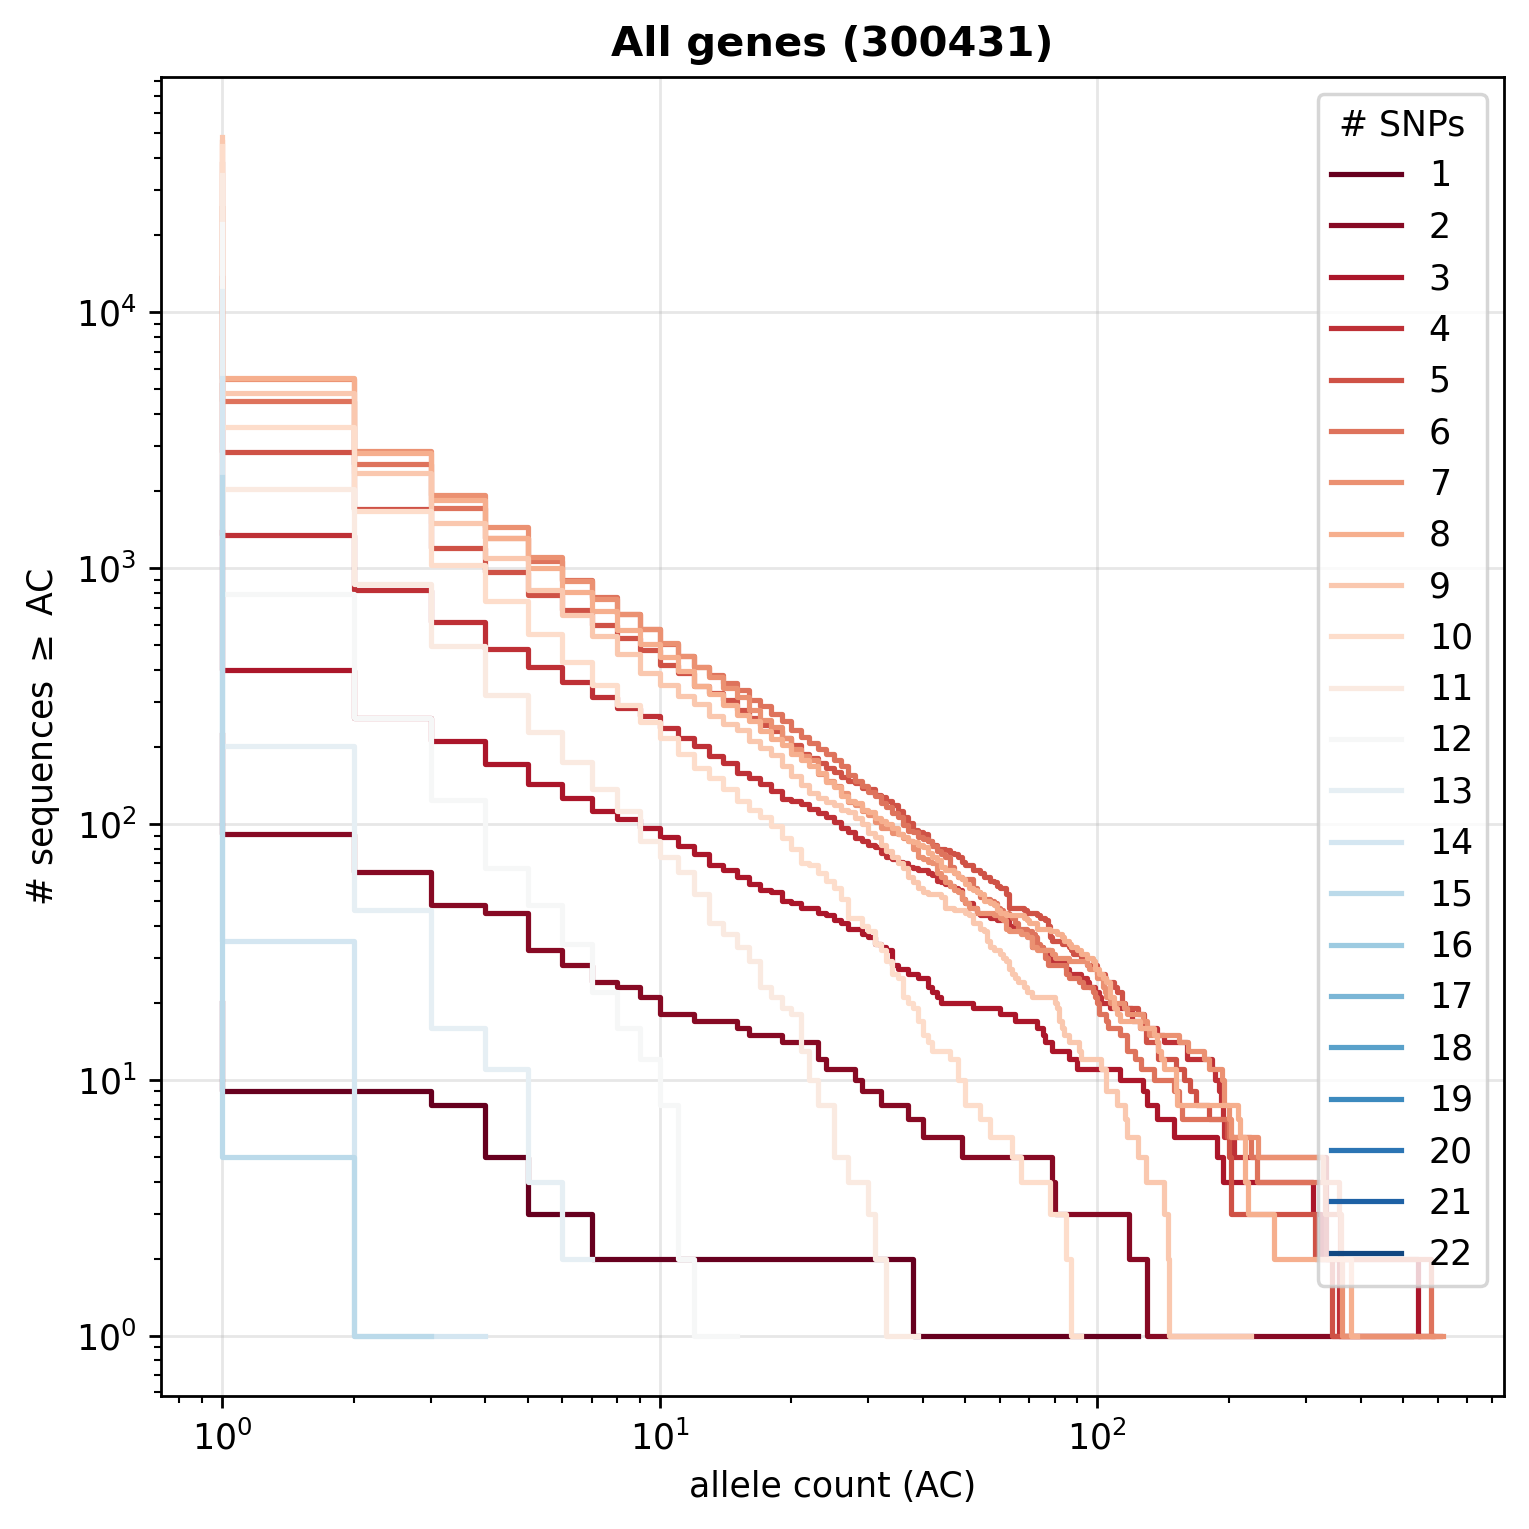

In [182]:
fig, ax = plt.subplots(figsize = (6,6), constrained_layout=True)

plotting_utils.plot_sequence_variation_content("All genes", data.sequences['all'], ax)

fig.savefig('total_variation.png')